## Loading a Test Data Set onto a HW Device for testing KP

In this tutorial, we will go over a method for testing your Knowledge Packs on a device by using a test data set.

This tutorial will walk through:
    1. Creating a model from some generated test data
    2. Creating a Pandas Dataframe of test data to load to the server
    3. Building a Knowledge Pack for a target device with that loaded test data on the device.

Once you have completed this tutorial you will have a KP that will read from the test data in place of the usual sensor data, looping through it continuously. This is a good first approach to testing any new Knowledge Pack on a device.

In [1]:
#standard imports
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

from sensiml import SensiML

### Connect to sensiml.cloud

In [2]:
client = SensiML()
client.project ='Device Debug Test' # If you made a personal project name, update this string before executing
client.pipeline = 'WindowingTest'

### Generate Training data

our client application has some built in data generation functions that allow for creating simple test data. The two main ones are the step and harmonic dataset generators. In this tutorial we will use the step generator to create a dataset with 3-axis sensor data and 3 different classes. 

In [3]:
sensor_columns = ['AccelerometerX','AccelerometerY','AccelerometerZ']
window_size = 50
num_classes = 3
num_iterations = 5

df = client.datasets.generate_step_data(window_size=window_size,num_classes=num_classes, num_iterations=num_iterations)
for index, column in enumerate(sensor_columns):
    df[column] = client.datasets.generate_step_data(window_size=window_size, num_classes=num_classes, scale_factor=index*10, num_iterations=num_iterations)['Data']
df.drop('Data', axis=1, inplace=True)

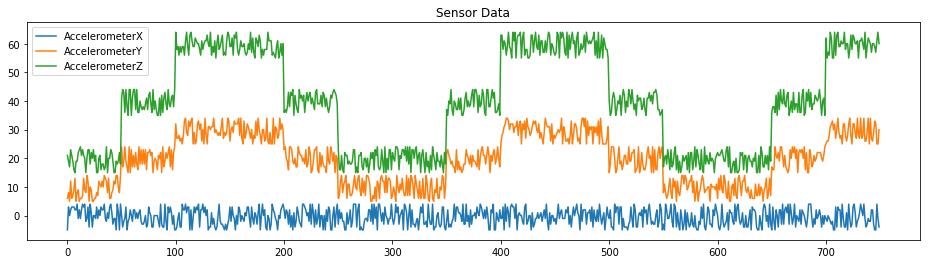

In [4]:
df[sensor_columns].plot(figsize=(16,4), title='Sensor Data')

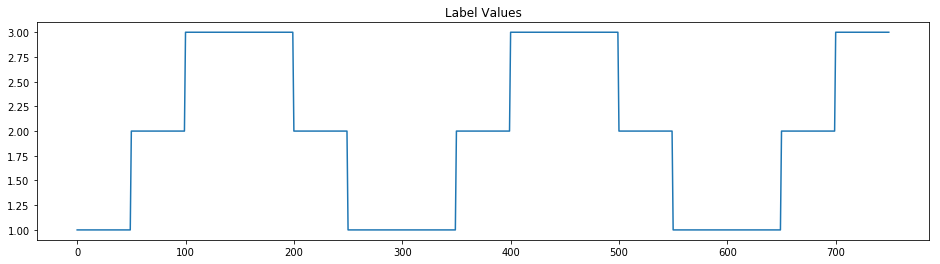

In [5]:
df['Label'].plot(figsize=(16,4), title='Label Values')

### Load the Test data up to the SensiML Cloud


Note: that a .csv is appended to filenames without a scv

In [7]:
client.upload_dataframe('window_test', df)

Uploading file "window_test" to KB Cloud.
Upload of file "window_test.csv"  to KB Cloud completed.


### Build a Test Pipeline

For this tutorial we are building a simple pipeline that applies a sliding window to the data set. The window size is 50 samples wide and slides forward 50 samples after every classification.

In [8]:
client.pipeline.reset()
client.pipeline.set_input_data('window_test.csv', group_columns=['Label'], 
                                               label_column='Label',
                                               data_columns=sensor_columns, 
                                               )


### Add windowing segmentation, Feature generators and scale the features to between 0-254 to the pipeline

In [9]:
client.pipeline.add_transform("Windowing", params={"window_size": window_size, "delta": window_size})

In [10]:
client.pipeline.add_feature_generator([{'name':'Mean','params':{"columns": sensor_columns}}])

In [11]:
client.pipeline.add_transform('Min Max Scale')

### Add a training algorithm (Pattern Matching Engine or PME) to recognize the different classes

In [12]:
client.pipeline.set_validation_method('Recall')

client.pipeline.set_classifier('PME', params={"classification_mode":'RBF','distance_mode':'L1'})

client.pipeline.set_training_algorithm("RBF with Neuron Allocation Optimization", params={"number_of_iterations": 2, "number_of_neurons":4})
#client.pipeline.set_training_algorithm("Hierarchical Clustering with Neuron Optimization", params={"number_of_neurons": 5})

client.pipeline.set_tvo({'validation_seed':0})

### Run the constructed pipeline on sensiml.cloud

In [13]:
results, stats = client.pipeline.execute()

Executing Pipeline with Steps:

------------------------------------------------------------------------
 0.     Name: window_test.csv           		Type: featurefile              
------------------------------------------------------------------------
------------------------------------------------------------------------
 1.     Name: Windowing                 		Type: segmenter                
------------------------------------------------------------------------
------------------------------------------------------------------------
 2.     Name: generator_set             		Type: generatorset             
------------------------------------------------------------------------
------------------------------------------------------------------------
 3.     Name: Min Max Scale             		Type: transform                
------------------------------------------------------------------------
------------------------------------------------------------------------
 4.     Name: t

### Check the performance of your model

In [14]:
results.summarize()

TRAINING ALGORITHM: RBF with Neuron Allocation Optimization
VALIDATION METHOD:  Recall
CLASSIFIER:         PVP

AVERAGE METRICS:
F1-SCORE:    100.0   sigma 0.00
SENSITIVITY: 100.0   sigma 0.00
PRECISION:   100.0   sigma 0.00

--------------------------------------

RECALL MODEL RESULTS

MODEL INDEX: Fold 0, Iteration 1
ACCURACY: 100.00
NEURONS: 3

MODEL INDEX: Fold 0, Iteration 0
ACCURACY: 100.00
NEURONS: 3



### View the results by plotting the neurons vs Average value for each Classes Feature Vectors

* solid lines are feature vector averages
* dotted lines are neurons

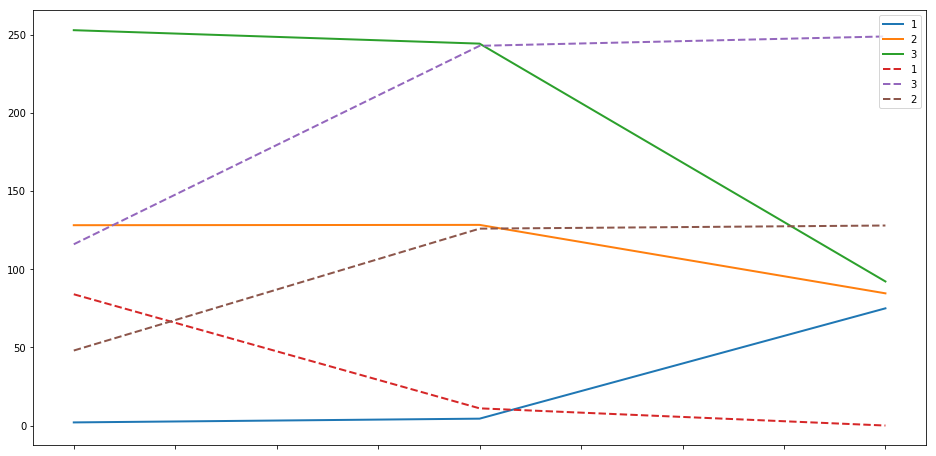

In [15]:
feature_vectors = client.pipeline.data(3)
model = results.configurations[0].models[0]

hist = feature_vectors.drop(['SegmentID'], axis=1)
group = hist.groupby(['Label']).apply(np.mean)
group.transpose().drop('Label', axis=0).plot(figsize=(16,8), lw=2)
#group.transpose().plot(figsize=(16,8), lw=2)

for neuron in model.neurons:
    plt.plot(neuron['Vector'], ls='--', lw=2, label=neuron['Category'])
plt.legend(loc='best')

### If everything looks good, lets save the model with a name so that we can download it as a KP for our device

In [16]:
model.knowledgepack.save('DebugKP')

Knowledgepack name updated.


### Upload some data to put onto the device as a test vector

In [17]:
client.upload_dataframe('TestData', df.iloc[:1000], force=True)

Uploading file "TestData" to KB Cloud.
Upload of file "TestData.csv"  to KB Cloud completed.


### Downloading the Knowledge Pack

Next, you just need to download the Knowledge Pack. See intructions for setting up the API for downloading a Knowledge Pack for your platform of choice at https://sensiml.com/documentation/sensiml-python-sdk/api-methods/knowledge-packs.html